# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [ ]:
data0.info()
data0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
mean_0 = data0['product'].mean()
mean_0

92.50000000000001

In [ ]:
data0.duplicated().sum()

0

In [ ]:
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
mean_1 = data1['product'].mean()
mean_1

68.82500000000002

In [ ]:
data1.duplicated().sum()

0

In [ ]:
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [ ]:
mean_2 = data2['product'].mean()
mean_2

95.00000000000004

In [ ]:
data2.duplicated().sum()

0

In [ ]:
data0['id'].duplicated().sum()

10

In [ ]:
data1['id'].duplicated().sum()

4

In [ ]:
data2['id'].duplicated().sum()

4

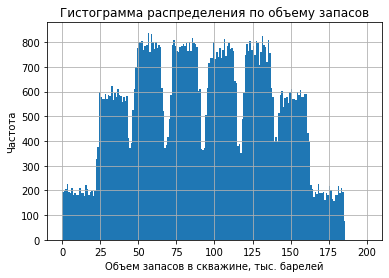

In [ ]:
data0['product'].hist(range=(0,200), bins = 200)
plt.xlabel("Объем запасов в скважине, тыс. барелей")
plt.ylabel("Частота")

plt.title("Гистограмма распределения по объему запасов")
plt.show()

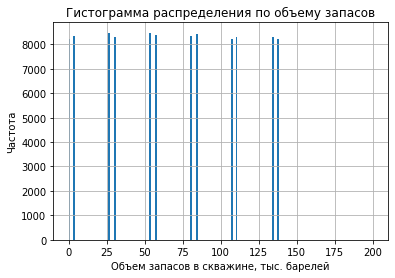

In [ ]:
data1['product'].hist(range=(0,200), bins = 200)
plt.xlabel("Объем запасов в скважине, тыс. барелей")
plt.ylabel("Частота")

plt.title("Гистограмма распределения по объему запасов")
plt.show()

In [ ]:
data1['product'].nunique()

12

Видим, что в столбце product второго датасета всего 12 повторяющихся значений, что объясняет такое распределение на графике.

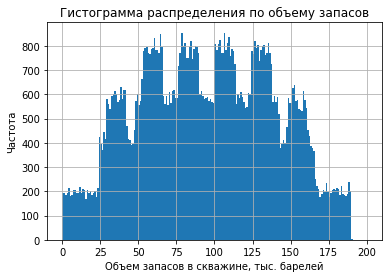

In [ ]:
data2['product'].hist(range=(0,200), bins = 200)
plt.xlabel("Объем запасов в скважине, тыс. барелей")
plt.ylabel("Частота")

plt.title("Гистограмма распределения по объему запасов")
plt.show()

Из полученных таблиц видим, что в каждом датасете имеется 5 столбцов, в каждом из которых 10000 строк (месторождений) без дубликатов и пропущенных значений. Также проверили дубликаты по столбцу id и нашли, что дубликаты имеются, значит, из некоторых скважин данные брались по несколько раз. 

id — уникальный идентификатор скважины.

Признаки:
*f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы).

Целевой признак:
*product* — объём запасов в скважине (тыс. баррелей).

Из гистограмм видно, что в первом и третьем регионе распределение близко к нормальному, в то время как во втором регионе некоторые данные отсутствуют, что в дальнейшем может повлиять на обучение модели.

Также получили средний запас сырья в скважине в каждом регионе:
- в первом: 92.5 тыс. баррелей;
- во втором: 68.8 тыс. баррелей;
- в третьем: 95 тыс. баррелей.

## Обучение и проверка модели

In [ ]:
def train_valid(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [ ]:
features_train0, features_valid0, target_train0, target_valid0 = train_valid(data0)
features_train1, features_valid1, target_train1, target_valid1 = train_valid(data1)
features_train2, features_valid2, target_train2, target_valid2 = train_valid(data2)

In [ ]:
def lr_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    mean = predictions_valid.mean()
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5 
    return mean, rmse, predictions_valid

In [ ]:
mean0, rmse0, predictions_valid0 = lr_model(features_train0, target_train0, features_valid0, target_valid0)
print("Результаты в первом регионе")
print("Средний запас предсказанного сырья:", mean0)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse0)

Результаты в первом регионе
Средний запас предсказанного сырья: 92.59256778438038
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


In [ ]:
mean1, rmse1, predictions_valid1 = lr_model(features_train1, target_train1, features_valid1, target_valid1)
print("Результаты во втором регионе")
print("Средний запас предсказанного сырья:", mean1)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse1)

Результаты во втором регионе
Средний запас предсказанного сырья: 68.728546895446
RMSE модели линейной регрессии на валидационной выборке: 0.893099286775616


In [ ]:
mean2, rmse2, predictions_valid2 = lr_model(features_train2, target_train2, features_valid2, target_valid2)
print("Результаты в третьем регионе")
print("Средний запас предсказанного сырья:", mean2)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse2)

Результаты в третьем регионе
Средний запас предсказанного сырья: 94.96504596800489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


При обучении и проверки модели для каждого региона наилучшие результаты среднего запаса сырья получены в третьем регионе - 94.97 тыс. баррелей, при этом корень из средней квадратичной ошибки самый высокий среди всех результатов - 40.03. Наименьшая ошибка в датасете второго региона - 0.89, при этом средний запас предсказанного сырья - наименьший, 68.73 тыс. баррелей.

## Подготовка к расчёту прибыли

В данном шаге необходимо посчитать достаточный объём сырья для безубыточной разработки новой скважины, то есть среднее количество бареллей в скважине при условии, что бюджет на разработку скважин в регионе равен общему доходу с 200 точек.

In [ ]:
BUDGET = 10_000_000_000
INCOME_PER_UNIT = 450_000

In [ ]:
BREAKEVEN = BUDGET/INCOME_PER_UNIT
print("Точка безубыточности (в тыс. бареллей):", BREAKEVEN)

Точка безубыточности (в тыс. бареллей): 22222.222222222223


In [ ]:
BREAKEVEN_PER_UNIT = BREAKEVEN/200
print("Достаточный объём сырья для безубыточной разработки новой скважины (в тыс. баррелей):", BREAKEVEN_PER_UNIT)

Достаточный объём сырья для безубыточной разработки новой скважины (в тыс. баррелей): 111.11111111111111


Получили минимальное количество баррелей для безубыточной разработки - 111 тыс. баррелей. Сравнивая со средним запасом в каждом регионе, видим, что везде запас сырья ниже.

## Расчёт прибыли и рисков 

В данном шаге необходимо написать функцию для расчета прибыли от полученного объема сырья, выбрав при этом 200 лучших скважин в каждом регионе. Также посчитать риски.

In [ ]:
target_valid0 = target_valid0.reset_index(drop=True)
target_valid1 = target_valid1.reset_index(drop=True)
target_valid2 = target_valid2.reset_index(drop=True)
predictions_valid0 = pd.Series(predictions_valid0)
predictions_valid1 = pd.Series(predictions_valid1)
predictions_valid2 = pd.Series(predictions_valid2)

In [ ]:
def profit_fun(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:200]
    product = selected_points.sum()
    revenue = product * INCOME_PER_UNIT
    return revenue - BUDGET

In [ ]:
state = np.random.RandomState(1234)

def profit_risk(target, predictions):
    revenues = []
    for i in range(1000):
        target_sample = target.sample(n=500, replace = True, random_state = state)
        predictions_sample = predictions[target_sample.index]
        revenues.append(profit_fun(target_sample, predictions_sample))
        
    revenues = pd.Series(revenues)
    
    lower = revenues.quantile(0.025)
    upper = revenues.quantile(0.975)
    profit = revenues.mean()
    risk = stats.percentileofscore(revenues, 0)
    return (lower, upper, profit, risk)

In [ ]:
lower0, upper0, profit0, risk0 = profit_risk(target_valid0,predictions_valid0)
print("Средняя прибыль:", profit0)
print("95%-й доверительный интервал:", (lower0, upper0))
print("Риск:", risk0)

Средняя прибыль: 417818853.4774105
95%-й доверительный интервал: (-112839919.44204798, 964934886.248598)
Риск: 6.0


In [ ]:
lower1, upper1, profit1, risk1 = profit_risk(target_valid1,predictions_valid1)
print("Средняя прибыль:", profit1)
print("95%-й доверительный интервал:", (lower1, upper1))
print("Риск:", risk1)

Средняя прибыль: 528866555.6440107
95%-й доверительный интервал: (118020423.53374399, 920140141.8573939)
Риск: 0.3


In [ ]:
lower2, upper2, profit2, risk2 = profit_risk(target_valid2,predictions_valid2)
print("Средняя прибыль:", profit2)
print("95%-й доверительный интервал:", (lower2, upper2))
print("Риск:", risk2)

Средняя прибыль: 410033672.5764216
95%-й доверительный интервал: (-97657713.7079339, 952816919.5140897)
Риск: 6.8


Из полученных результатов видим, что наибольшую прибыль и минимальный риск показал второй регион, но так как данные второго региона неполные, предлагать его для разработки в данном случае неприемлемо. Из двух других регионов большую прибыль и наименьший риск имеет первый регион с результатами: 
- Средняя прибыль: 417818853.4774105
- 95%-й доверительный интервал: (-112839919.44204798, 964934886.248598)
- Риск: 6.0

## Вывод

В данном проекте были проанализированы данные из трех регионов для определения бурения новой скважины. В отличие от других регионов во втором модель имела хорошие предсказания, что объясняется тем, что в данных было всего 12 уникальных значений запасов в скважине.

Из двух других регионов наибольшая средняя прибыль у первого - 417.8 млн рублей, 95% доверительный интервал: (-112.8, 964.9) млн рублей, и наименьший риск - 6%. При этом минимальный запас сырья в скважине для безубыточной разработки должен быть равен - 111.11 тыс. баррелей.

Исходя из результатов я бы рекомендовала первый регион для разработки скважин.